In [2]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import pandas as pd
from sqlalchemy import create_engine
import time
from h2o.automl import H2OAutoML
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix
import xgboost as xgb

from random import shuffle

### doing this with keras
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def draw_roc_keras(model,xt, yt):
    predictions = model.predict(xt)
    # for in in range(2):
    fpr, tpr, thr = roc_curve(yt, predictions[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format('keras'))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return predictions

tf.__version__
# tn= tf.keras.utils.normalize(train_only_pd)


def conv_tf(l):
    l_b=[]
    for i in l:
        if i[0] == True:
            l_b.append('YES')
        else:
            l_b.append('NO')
    return np.array(l_b)



def conv_b(l):
    l_b=[]
    for i in l:
        if i=='YES':
            l_b.append(1)
        else:
            l_b.append(0)
    return np.array(l_b)

def conv_s(l):
    l_s=[]
    for i in l:
        if i==1:
            l_s.append('YES')
        else:
            l_s.append('NO')
    return np.array(l_s)


def conf_m(t,real_l,pred_l):
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append('YES')
        else:
            pred_thr.append('NO')
    return confusion_matrix(real_l, pred_thr)



# class Model(object):
#     def __init__(self, model, name):
#         self.model = model
#         self.name = name
#
#     def train(self, x, y, training_frame, validation_frame):
#         self.model.train(x=x, y=y, training_frame=training_frame, validation_frame=validation_frame)


def readable_time(seconds):
    """Returns h:mm:ss formatted time from time in seconds.

    Args:
        seconds (float): Number of seconds to convert to readable time.

    """
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return "%d:%02d:%02d" % (h, m, s)


def confusion_matrix_max(frame, pred_col, real_col, threshold):
    """Creates a confusion matrix based on the truth value of the predictions and a threshold.

    Args:
        frame (H2OFrame, DataFrame): Frame with headers.
        pred_col (str): Name of column with predictions.
        real_col (str): Name of column with actuals.
        threshold (float): Threshold determining vote of prediction column.

    Returns:
        ConfusionMatrix
    """
    predicted = frame[pred_col].apply(lambda row: 1 if row >= threshold else 0)
    real = frame[real_col]
    matrix = ConfusionMatrix(list(real), list(predicted))

    return matrix, matrix.precision, threshold


def draw_roc(frame,model,if_print=True):
    """Plots and ROC curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame 
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    real = conv_tf(frame['if_failed'].as_data_frame().values)
    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['True']

    fpr, tpr, thr = roc_curve(conv_b(real), p_yes_dnn)
    roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                dtp_dnn = dtp_dnn.append(
                    {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                    ignore_index=True)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return pred_model

In [33]:

##Load Data
train_data=pd.read_csv('../Data/train.csv')
train_data.drop(['xfrmr'], axis=1, inplace=True)

## Import test data
test_data=pd.read_csv('../Data/test.csv')
test_df=test_data[['xfrmr','if_failed']]
test_data.drop(['xfrmr'], axis=1, inplace=True)



train_data=train_data.sample(frac=1)
### dropping voltage
# train_data.drop(train_data.columns[2:52],axis=1, inplace=True)



# Define not failed to failed ratio
not_failed_to_failed_ratio = 1


# Create train and validation sets
failed_table = train_data[train_data['if_failed'] == True]
not_failed_table = train_data[train_data['if_failed'] == False][:not_failed_to_failed_ratio * len(failed_table)]


# # train_pd = train_data
# # train_pd = train_pd.sample(frac=1)
# train_pd = failed_table[:int(0.8 * len(failed_table))].append(not_failed_table[:int(0.8 * len(not_failed_table))])
# train_pd =train_pd.sample(frac=1)


# # val_pd = failed_table[int(0.6 * len(failed_table)):int(0.8 * len(failed_table))].append(not_failed_table[int(0.6 * len(not_failed_table)):int(0.8 * len(not_failed_table))])
# val_pd= failed_table[int(0.8 * len(failed_table)):].append(not_failed_table[int(0.8 * len(not_failed_table)):])
# val_pd=val_pd.sample(frac=1)


# test_pd= failed_table[int(0.6 * len(failed_table)):].append(not_failed_table[int(0.6 * len(not_failed_table)):])
train_only_pd = failed_table.append(not_failed_table)
train_only_pd=train_only_pd.sample(frac=1)


predictors = train_only_pd.columns[1:-1]
response = 'if_failed'


scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(train_only_pd[predictors])

x_train=train_only_pd[predictors]
y_train=train_only_pd[response]

x_test=test_data[predictors]
y_test=test_data[response]


x_train= scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [34]:
# print(x_train[0], "\n", x_test[0], "\n", y_train[0], "\n",y_test[0])
# print(x_train[0].shape)
x_train.shape

(590, 15)

Epoch 1/5
 - 1s - loss: 0.7015 - acc: 0.4864
Epoch 2/5
 - 0s - loss: 0.6966 - acc: 0.4949
Epoch 3/5
 - 0s - loss: 0.6922 - acc: 0.5576
Epoch 4/5
 - 0s - loss: 0.6890 - acc: 0.6068
Epoch 5/5
 - 0s - loss: 0.6864 - acc: 0.6153


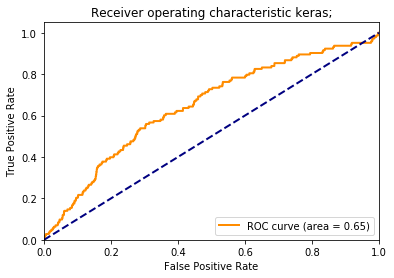

In [35]:
model= tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(15, )))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

model.compile(optimizer= 'adam',
              loss= 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(x_train, y_train, verbose =2, epochs = 5,batch_size=800)
pred=draw_roc_keras(model,[x_test], y_test)

In [36]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(val_loss, val_accuracy)

148796/148796 [==============================] - ETA: 21:5 - ETA: 36s  - ETA: 19 - ETA: 14 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 39us/step
0.6769065564270125 0.9156899379031588


In [ ]:
predc=model.predict_classes([x_test])
predc

## Trying LSTM 

In [35]:
x_train.shape

(197772, 15)